# Wrangling data with Spark

In [1]:
# Lets import the nessary packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In order to connect to spark and interact with it we need to create a spark session.  To create a spark session we will code as follows. 

In [3]:
spark = SparkSession \
    .builder \
    .appName("Data Wrangling with Spark SQL") \
    .getOrCreate()

checks if the session was created successfuly 


In our data folder we have a file called database.csv  which conttains the records for the dataset birdstrike.  The dataset was sourced out of kaggle.com  This is the dataset we will be utilizing to demonstrate how to wrangle data using spark.  Again spark is used to process big data in clusters.  The steps in this work session will guage on my skills using spark.  

In [35]:
path = "data/database.csv"
strike = spark.read.csv(path, header=True, inferSchema=True)

after reading the file into spark lets print its schema. 

In [36]:
strike.printSchema()

root
 |-- Record ID: integer (nullable = true)
 |-- Incident Year: integer (nullable = true)
 |-- Incident Month: integer (nullable = true)
 |-- Incident Day: integer (nullable = true)
 |-- Operator ID: string (nullable = true)
 |-- Operator: string (nullable = true)
 |-- Aircraft: string (nullable = true)
 |-- Aircraft Type: string (nullable = true)
 |-- Aircraft Make: string (nullable = true)
 |-- Aircraft Model: string (nullable = true)
 |-- Aircraft Mass: integer (nullable = true)
 |-- Engine Make: integer (nullable = true)
 |-- Engine Model: string (nullable = true)
 |-- Engines: integer (nullable = true)
 |-- Engine Type: string (nullable = true)
 |-- Engine1 Position: string (nullable = true)
 |-- Engine2 Position: integer (nullable = true)
 |-- Engine3 Position: string (nullable = true)
 |-- Engine4 Position: integer (nullable = true)
 |-- Airport ID: string (nullable = true)
 |-- Airport: string (nullable = true)
 |-- State: string (nullable = true)
 |-- FAA Region: string (nu

In [37]:
strike.toPandas().head(1)

,Record ID,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,...,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage
0,127128,1990,1,1,DAL,DELTA AIR LINES,B-757-200,A,148,26,...,0,0,0,0,1,1,0,0,0,0


Our next steps is to create view and run queries against it

In [38]:
strike.createOrReplaceTempView('birdstrike')

In [39]:
spark.sql("select * from birdstrike limit 2").toPandas()

,Record ID,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,...,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage
0,127128,1990,1,1,DAL,DELTA AIR LINES,B-757-200,A,148,26,...,0,0,0,0,1,1,0,0,0,0
1,129779,1990,1,1,HAL,HAWAIIAN AIR,DC-9,A,583,90,...,0,0,0,0,0,0,0,0,1,0


In [91]:
damage_over = spark.sql("""
       select `Incident Year` || lpad(`Incident Month`, 2, '0')  as yearmonth
        , sum(`Aircraft Damage`) as totalDamage

        from birdstrike
        group by 1
        order by 1
            """)

In [92]:
damage_pd = damage_over.toPandas()

In [95]:
damage_pd.head(10)

,yearmonth,totalDamage
0,199001,10
1,199002,11
2,199003,10
3,199004,15
4,199005,31
5,199006,34
6,199007,40
7,199008,35
8,199009,56
9,199010,69


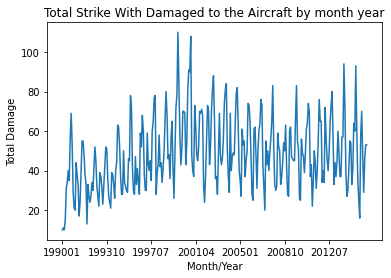

In [96]:
fig, ax = plt.subplots()
ax.plot(damage_pd['yearmonth'], damage_pd['totalDamage'])
ax.set_xticks(ax.get_xticks()[::45])
plt.ylabel('Total Damage')
plt.xlabel('Month/Year')
plt.title('Total Strike With Damaged to the Aircraft by month year')
plt.show()

In [66]:
damaged_aircraft = spark.sql(
"""
    select Aircraft
        , sum(`Aircraft Damage`) as totalDamge
    from birdstrike 
    group by 1
    order by 2 desc
    limit 10

"""

).toPandas()

In [67]:
damaged_aircraft.head()

,Aircraft,totalDamge
0,B-737-300,975
1,B-757-200,680
2,A-320,515
3,C-172,460
4,CRJ100/200,380


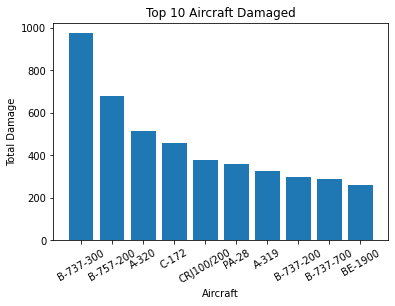

In [74]:
plt.bar(damaged_aircraft['Aircraft'], damaged_aircraft['totalDamge'])
plt.xlabel('Aircraft')
plt.ylabel('Total Damage')
plt.title('Top 10 Aircraft Damaged')
plt.xticks(rotation=30)
plt.show()